# Environment Setup

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

## Paths to ZIP files and extraction

In [6]:
!unzip -qo "/content/drive/My Drive/Colab Notebooks/Final_Project_data/train_data_unlabeled.zip" -d '/content/train_data'
!unzip -qo "/content/drive/My Drive/Colab Notebooks/Final_Project_data/test_data_unlabeled.zip" -d '/content/test_data'
x_train_extracted_path = "/content/train_data/train_data_unlabeled"
x_test_extracted_path = "/content/test_data/test_data_unlabeled"

## Load and preprocess images

In [7]:
# Load images

def load_images(folder_path):
    images, valid_image_names = [], []
    for name in sorted(os.listdir(folder_path), key=lambda x: int(x.split('_')[1][:-4])):
        if name.startswith("img_") and name.endswith(".png"):
            img = Image.open(os.path.join(folder_path, name))
            img = np.array(img)[:,:,:3]  # Keep only the first 3 channels (RGB)
            images.append(img)
    return np.array(images)

x_train_images = load_images(x_train_extracted_path)
x_test_images = load_images(x_test_extracted_path)
y_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Final_Project_data/y_train.csv')
y_train_encoded = to_categorical(y_train.target)

# Split into training and validation sets
x_train, x_val, y_train_encoded, y_val_encoded = train_test_split(x_train_images, y_train_encoded, test_size=0.2, random_state=42)

# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

# Model Building

In [8]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(x_train.shape[1:])),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(4, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Training


In [9]:
history = model.fit(x_train, y_train_encoded, epochs=30, validation_data=(x_val, y_val_encoded))

Epoch 1/30
405/405 [==============================] - 54s 129ms/step - loss: 0.6554 - accuracy: 0.7252 - val_loss: 0.3975 - val_accuracy: 0.8533
Epoch 2/30
405/405 [==============================] - 51s 125ms/step - loss: 0.3572 - accuracy: 0.8624 - val_loss: 0.2936 - val_accuracy: 0.8879
Epoch 3/30
405/405 [==============================] - 50s 123ms/step - loss: 0.2685 - accuracy: 0.9000 - val_loss: 0.2603 - val_accuracy: 0.9049
Epoch 4/30
405/405 [==============================] - 50s 124ms/step - loss: 0.2276 - accuracy: 0.9125 - val_loss: 0.2040 - val_accuracy: 0.9271
Epoch 5/30
405/405 [==============================] - 49s 120ms/step - loss: 0.2063 - accuracy: 0.9217 - val_loss: 0.2230 - val_accuracy: 0.9098
Epoch 6/30
405/405 [==============================] - 49s 120ms/step - loss: 0.1651 - accuracy: 0.9374 - val_loss: 0.1572 - val_accuracy: 0.9416
Epoch 7/30
405/405 [==============================] - 51s 126ms/step - loss: 0.1514 - accuracy: 0.9441 - val_loss: 0.1925 - val_ac

# Model Evaluation and Visualization


## Plot training history

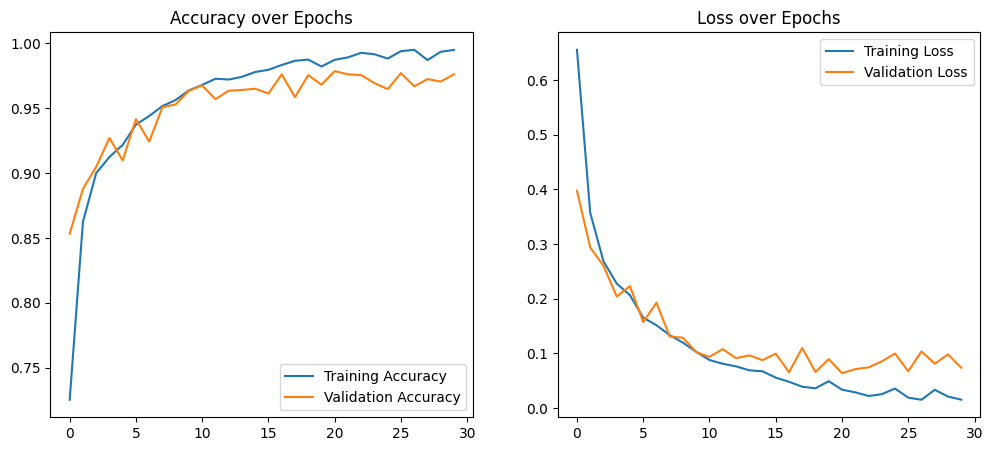

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

## Confusion Matrix Visualization

102/102 [==============================] - 4s 35ms/step


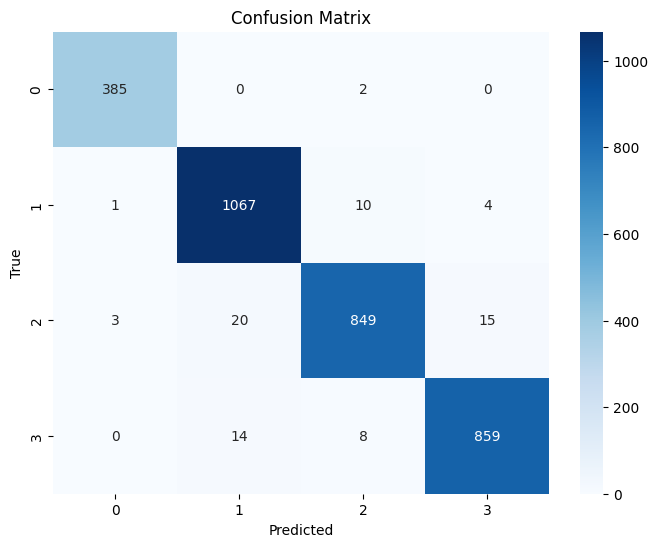

In [11]:
val_pred_labels = np.argmax(model.predict(x_val), axis=1)
y_true_labels = np.argmax(y_val_encoded, axis=1)

cm = confusion_matrix(y_true_labels, val_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## performance metrics

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true_labels, val_pred_labels)
precision = precision_score(y_true_labels, val_pred_labels, average='weighted')
recall = recall_score(y_true_labels, val_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, val_pred_labels, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9762
Precision: 0.9763
Recall: 0.9762
F1 Score: 0.9762


# Submission

In [14]:
# Predict on test data
test_predictions = model.predict(x_test_images)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': np.arange(len(test_pred_classes)),
    'target': test_pred_classes
})

# Define submission file path
submission_file_path = '/content/drive/My Drive/Colab Notebooks/Final_Project_data/submission.csv'
# Save submission file
submission_df.to_csv(submission_file_path, index=False)

# Display first few rows to verify
print(submission_df.head())

# Optional: Visualize some predictions
def visualize_predictions(images, true_labels, pred_labels, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].reshape(images.shape[1], images.shape[2], -1))
        plt.title(f"True: {true_labels[i]}, Pred: {pred_labels[i]}")
        plt.axis('off')
    plt.show()

150/150 [==============================] - 4s 29ms/step
   id  target
0   0       2
1   1       3
2   2       3
3   3       1
4   4       2
